# Лабораторная работа 3

Выполнил студент группы J4240: Кондратов Павел Анатольевич

Данные доступны из прошлой лабы. Целевая переменная: Индекс промышленного производства


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima

# Данные

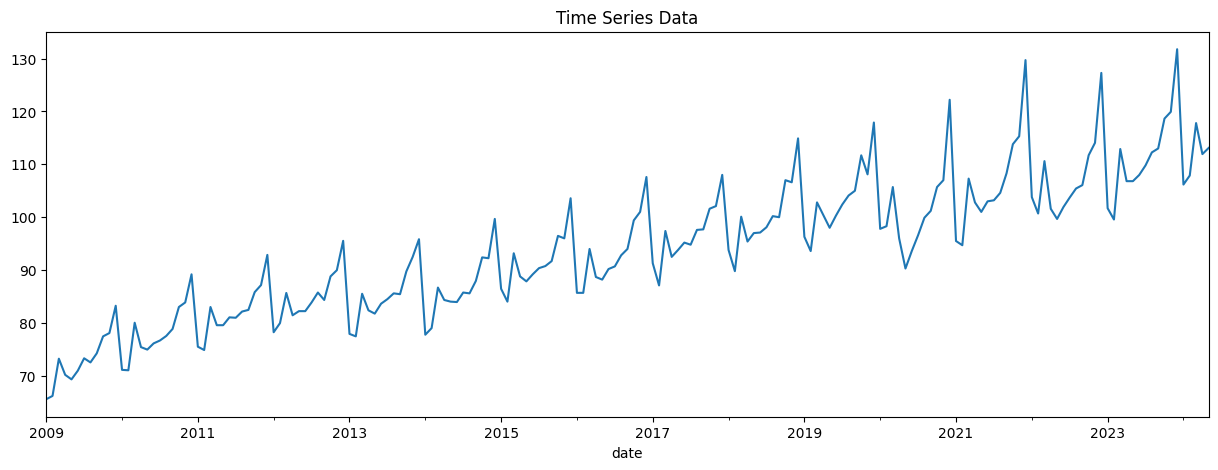

In [2]:
data = pd.read_excel(
    "Экономические данные.xlsx", parse_dates=["date"], index_col="date"
)
df = data.loc[data.index >= "2009-01-01", "Индекс промышленного производства"]

# рисуем график
df.plot(figsize=(15, 5), title="Time Series Data")
plt.show()

# оставляем 12 наблдюдений для теста (последний год)
train_size = len(df) - 12
train, test = df.iloc[:train_size], df.iloc[train_size:]

train.index = pd.DatetimeIndex(train.index.values, freq=train.index.inferred_freq)
test.index = pd.DatetimeIndex(test.index.values, freq=train.index.inferred_freq)

Очевидная сезонность в 12 месяцев. Плюс небольшой тренд

# Тест на стационарность

In [3]:
# Проводим тест на стацио
def adf_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC", regression="ct")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)


adf_test(df)

Results of Dickey-Fuller Test:
Test Statistic                  -3.655116
p-value                          0.025488
#Lags Used                      12.000000
Number of Observations Used    172.000000
Critical Value (1%)             -4.012392
Critical Value (5%)             -3.436330
Critical Value (10%)            -3.142220
dtype: float64


На уровне 1% принимаем нулевую гипотезу, что есть единичный корень. Значит нет стационарности

# ACF/PACF

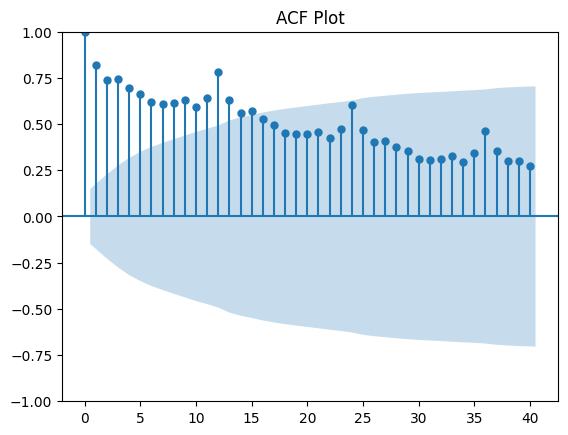

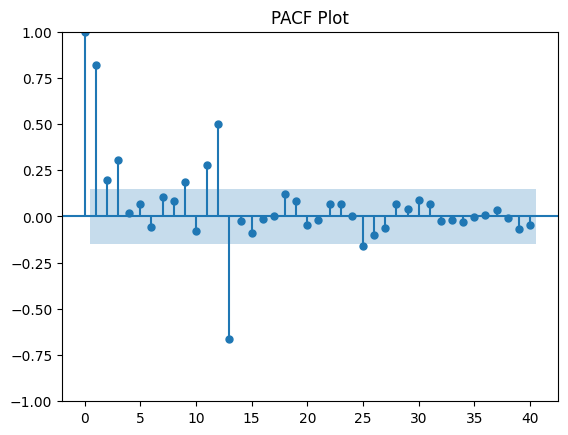

In [4]:
# 1. ACF and PACF Analysis
plot_acf(train, lags=40, title="ACF Plot")
plot_pacf(train, lags=40, title="PACF Plot")
plt.show()

В целом графики подтверждают предположение, что период сезонности 12 месяцев. Так как именно после 12 лага PACF правктически совпадает с нулем, а у ACF каждые 12 наблюдений видны пики.

# Разложение

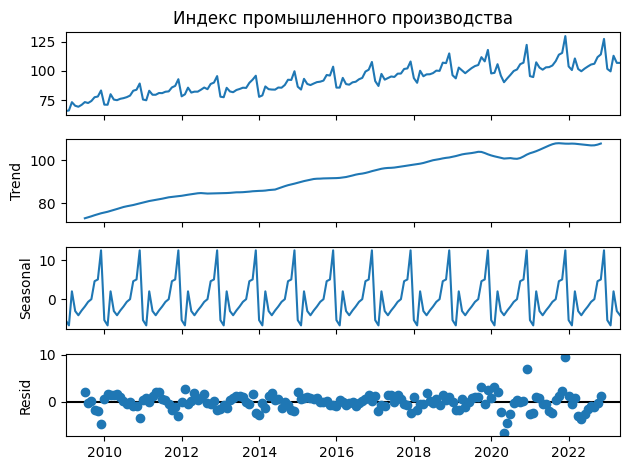

In [5]:
decomposition = seasonal_decompose(train, model="additive")
decomposition.plot()
plt.show()

Отлично получилось выделить тренд и сезонную компоненту. Остатки при этом близки к нулю - значит все хорошо.

# ARIMA base

In [6]:
import numpy as np


class MyARIMA:
    def __init__(self, p, d, q):
        """
        Инициализация

        Input:

            p - AR компонента

            d - проядок интеграции

            q - MA компонента

        Output:

            None

        """
        self.p = p
        self.d = d
        self.q = q
        self.coefficients = None
        self.ma_coefficients = None

    def difference(self, series, order):
        """
        Поиск разностей

        Input:

            series - исходный ряд

            order - порядок разностей

        Output:

            Подходящий ряд для модели

        """
        for _ in range(order):
            series = np.diff(series)
        return series

    def inverse_difference(self, original_series, differenced_series, order):
        """
        Обратное преобразование для получения прогноза

        Input:

            original_series - исходный ряд

            differenced_series - разностный ряд порядка order

            order - порядок разностей

        Output:

            Ряд подходящий для визуализации
        """
        for i in range(order):
            differenced_series = np.r_[
                original_series[-(i + 1)], differenced_series
            ].cumsum()
        return differenced_series

    def fit(self, series):
        """
        Обучение ARIMA

        Input:

            series - исходный ряд
        """
        # Получаем разности
        differenced_series = self.difference(series, self.d)

        # Делаем матрицу AR компонент
        X = np.zeros((len(differenced_series) - self.p, self.p + 1))
        for i in range(self.p):
            X[:, i] = differenced_series[self.p - i - 1 : -i - 1]

        X[:, -1] = 1

        #  Получаем коэффициенты AR процесса при помощи МНК оценки
        y = differenced_series[self.p :]
        self.coefficients = np.linalg.lstsq(X, y, rcond=None)[0]

        # Остатки для поиска коэффициентов MA процесса
        residuals = y - X @ self.coefficients

        # Аналогично набираем матрицу и ищем веса при помощи МНК
        if self.q > 0:
            Y = np.zeros((len(residuals) - self.q, self.q + 1))
            for i in range(self.q):
                Y[:, i] = residuals[self.q - i - 1 : -i - 1]
            Y[:, -1] = 1

            self.ma_coefficients = np.linalg.lstsq(Y, residuals[self.q :], rcond=None)[
                0
            ]
        else:
            self.ma_coefficients = np.array([])

    def predict(self, series, steps=1):
        """
        Предсказание для steps шагов вперед

        Input:

            series - исходный ряд

            steps - количество периодов для предсказания
        """
        # Получаем разности
        differenced_series = self.difference(series, self.d)
        predictions = []

        for _ in range(steps):
            # AR компонента
            ar_term = sum(
                self.coefficients[i] * differenced_series[-(i + 1)]
                for i in range(self.p)
            )
            ar_term += self.coefficients[-1]
            # MA компонента
            ma_term = 0
            if len(predictions) >= self.q:
                for i in range(self.q):
                    ma_term += self.ma_coefficients[i] * (
                        predictions[-(i + 1)] - differenced_series[-(i + 1)]
                    )
            ma_term += self.ma_coefficients[-1]

            # Предсказание
            forecast = ar_term + ma_term
            predictions.append(forecast)

            # Добавляем предсказание текущего шага
            differenced_series = np.append(differenced_series, forecast)

        # Делаем обратное преобразование
        return self.inverse_difference(series, predictions, self.d)

Выбираем коэффициенты согласно правилу

- Начальное приближение p: последний значимый пик у PACF.
- Начальное приближение q: последний значимый пик у ACF.


In [7]:
arima = MyARIMA(p=12, d=1, q=15)
arima.fit(train)
print(f"AR_coef: {arima.coefficients}\nMA_coef: {arima.ma_coefficients}")
forecast = arima.predict(train, steps=5)
print("Forecasted values:", forecast)

AR_coef: [-0.23280834 -0.23115037 -0.21540145 -0.22055451 -0.197451   -0.21390363
 -0.21737905 -0.20862149 -0.20047192 -0.22954986 -0.23638888  0.7716791
  0.57648738]
MA_coef: [-0.05593377 -0.02697169 -0.01509422  0.00050958  0.05625391  0.14630306
 -0.0909726   0.02650642  0.01102783 -0.01821591 -0.15417586 -0.39789004
 -0.1572376   0.0543352   0.01597306 -0.05098975]
Forecasted values: [106.8132     107.65822181 108.60354423 110.08048444 109.98167534
 114.54675548]


/var/folders/qf/5hbpzmlx4v57fv27989mpd7r0000gn/T/ipykernel_82383/2550303420.py:65: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  original_series[-(i + 1)], differenced_series


/var/folders/qf/5hbpzmlx4v57fv27989mpd7r0000gn/T/ipykernel_82383/2550303420.py:65: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  original_series[-(i + 1)], differenced_series


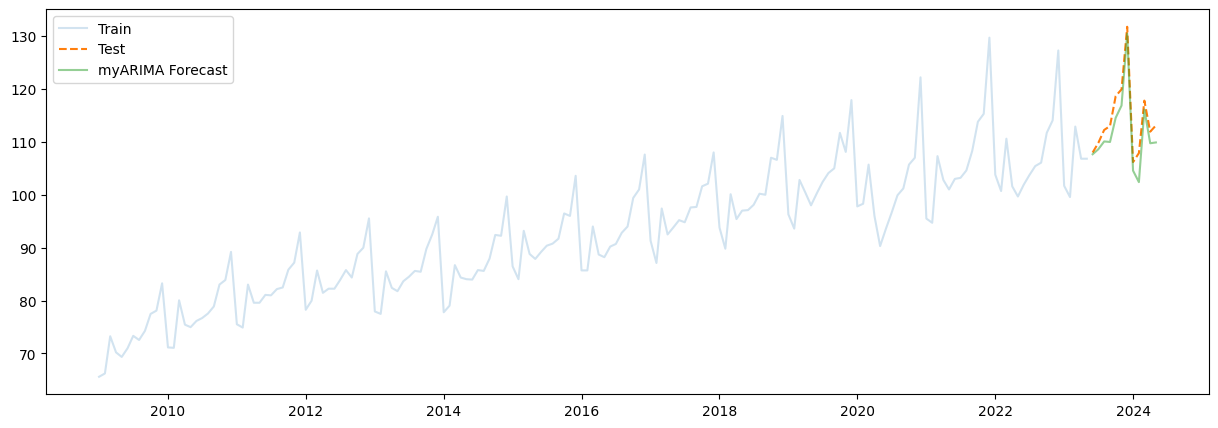

In [8]:
arima_forecast = arima.predict(train, steps=len(test))
plt.figure(figsize=(15, 5))
plt.plot(train, label="Train", alpha=0.2)
plt.plot(test, label="Test", linestyle="dashed")
plt.plot(test.index, arima_forecast[1:], label="myARIMA Forecast", alpha=0.5)
plt.legend()
plt.show()

In [9]:
arima_model = ARIMA(train, order=(12, 1, 14), trend="n")
arima_result = arima_model.fit()
print("ARIMA Summary:")
print(arima_result.summary())

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA Summary:
                                       SARIMAX Results                                       
Dep. Variable:     Индекс промышленного производства   No. Observations:                  173
Model:                              ARIMA(12, 1, 14)   Log Likelihood                -356.134
Date:                               Sun, 08 Dec 2024   AIC                            766.267
Time:                                       10:39:14   BIC                            851.249
Sample:                                   01-01-2009   HQIC                           800.747
                                        - 05-01-2023                                         
Covariance Type:                                 opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0243      0.089     -0.273      0.785      -0.199       0.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


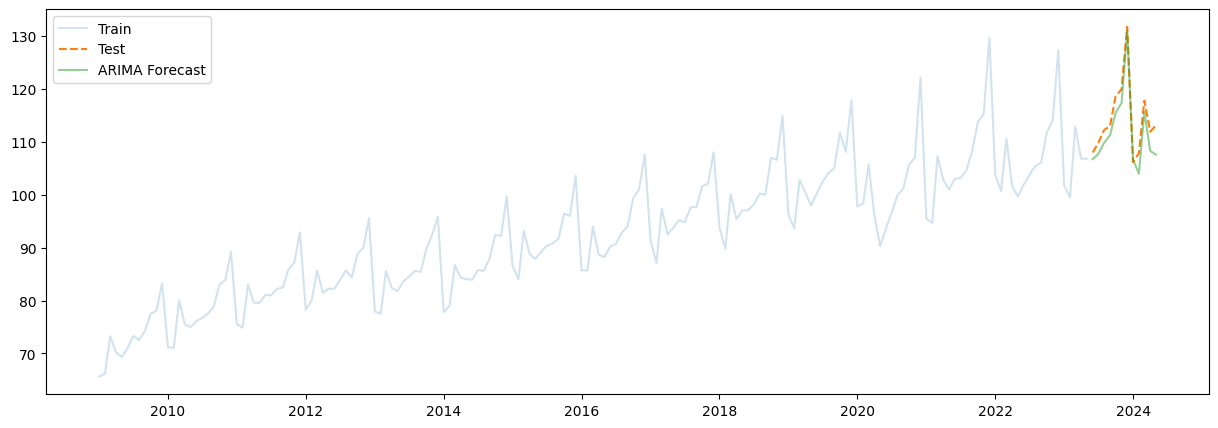

In [10]:
arima_forecast = arima_result.forecast(steps=len(test))
plt.figure(figsize=(15, 5))
plt.plot(train, label="Train", alpha=0.2)
plt.plot(test, label="Test", linestyle="dashed")
plt.plot(test.index, arima_forecast, label="ARIMA Forecast", alpha=0.5)
plt.legend()
plt.show()

Очень сильный бейслайн. У модели получилось неплохо предсказать значения на год. При этом моя реализация совпадает с пакетной

# AUTO ARIMA

In [11]:
arima_model = auto_arima(
    train,
    max_p=15,
    max_d=3,
    max_q=15,
    start_p=12,
    start_q=15,
    seasonal=False,
    trace=True,
    error_action="ignore",
    suppress_warnings=True,
    stepwise=True,
    with_intercept=True,
)

print("Best ARIMA parameters:", arima_model.order)

Performing stepwise search to minimize aic
 ARIMA(12,1,15)(0,0,0)[0] intercept   : AIC=770.635, Time=1.76 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1160.250, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1145.953, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1158.453, Time=0.01 sec
 ARIMA(11,1,15)(0,0,0)[0] intercept   : AIC=773.407, Time=1.57 sec
 ARIMA(12,1,14)(0,0,0)[0] intercept   : AIC=756.307, Time=1.64 sec
 ARIMA(11,1,14)(0,0,0)[0] intercept   : AIC=773.810, Time=1.70 sec
 ARIMA(12,1,13)(0,0,0)[0] intercept   : AIC=756.477, Time=1.23 sec
 ARIMA(13,1,14)(0,0,0)[0] intercept   : AIC=760.806, Time=1.45 sec
 ARIMA(11,1,13)(0,0,0)[0] intercept   : AIC=inf, Time=1.51 sec
 ARIMA(13,1,13)(0,0,0)[0] intercept   : AIC=756.353, Time=1.61 sec
 ARIMA(13,1,15)(0,0,0)[0] intercept   : AIC=762.279, Time=1.49 sec
 ARIMA(12,1,14)(0,0,0)[0]             : AIC=766.267, Time=1.48 sec

Best model:  ARIMA(12,1,14)(0,0

In [12]:
arima_model_best = ARIMA(train, order=(12, 1, 14), trend="t")
arima_result_best = arima_model_best.fit()
print("ARIMA Summary:")
print(arima_result_best.summary())

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


ARIMA Summary:
                                       SARIMAX Results                                       
Dep. Variable:     Индекс промышленного производства   No. Observations:                  173
Model:                              ARIMA(12, 1, 14)   Log Likelihood                -354.236
Date:                               Sun, 08 Dec 2024   AIC                            764.472
Time:                                       10:39:32   BIC                            852.602
Sample:                                   01-01-2009   HQIC                           800.229
                                        - 05-01-2023                                         
Covariance Type:                                 opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.2189      0.021     10.215      0.000       0.177       0.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


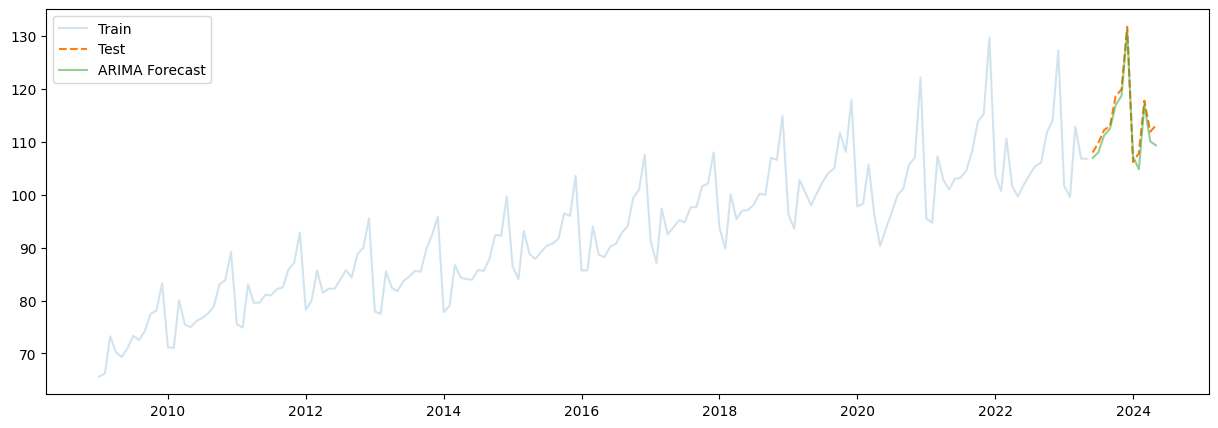

In [13]:
arima_forecast_best = arima_result_best.forecast(steps=len(test))
plt.figure(figsize=(15, 5))
plt.plot(train, label="Train", alpha=0.2)
plt.plot(test, label="Test", linestyle="dashed")
plt.plot(test.index, arima_forecast_best, label="ARIMA Forecast", alpha=0.5)
plt.legend()
plt.show()

Auto ARIMA это модель с автоподбором параметров ARIMA на основе штрафного критерия Акаике. Чем меньше значение критерия - тем лучше модель. Теперь предсказание стало еще лучше. Сравним с более сложными моделями

# SARIMA

In [66]:
sarima_model = SARIMAX(train, order=(0, 1, 1), seasonal_order=(0, 1, 1, 12))
sarima_result = sarima_model.fit(disp=False)
print("SARIMA Summary:")
print(sarima_result.summary())

SARIMA Summary:
                                       SARIMAX Results                                       
Dep. Variable:     Индекс промышленного производства   No. Observations:                  173
Model:                SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -327.297
Date:                               Sun, 08 Dec 2024   AIC                            660.593
Time:                                       11:00:00   BIC                            669.819
Sample:                                   01-01-2009   HQIC                           664.339
                                        - 05-01-2023                                         
Covariance Type:                                 opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.2717      0.046     -5.907      0.000      -0.362      -0

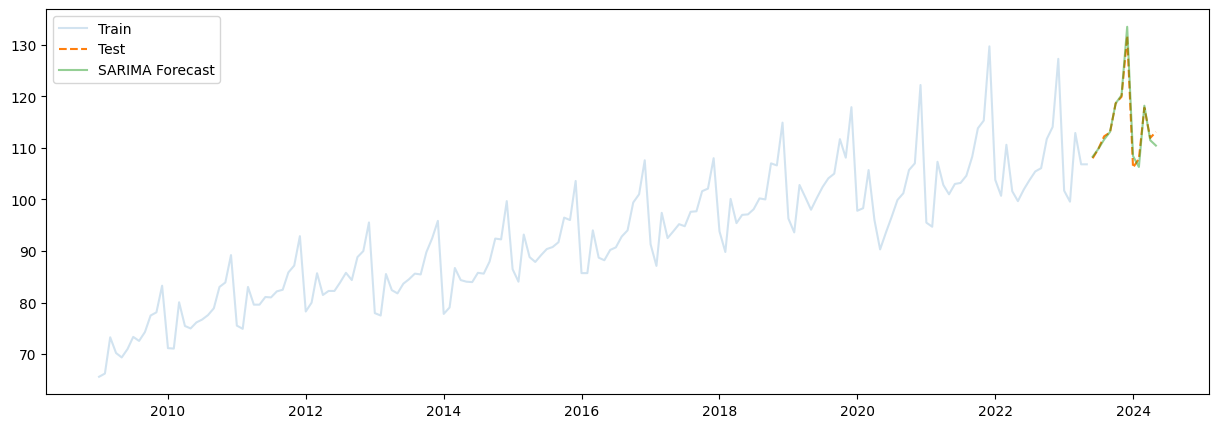

In [67]:
sarima_forecast = sarima_result.forecast(steps=len(test))
plt.figure(figsize=(15, 5))
plt.plot(train, label="Train", alpha=0.2)
plt.plot(test, label="Test", linestyle="dashed")
plt.plot(test.index, sarima_forecast, label="SARIMA Forecast", alpha=0.5)
plt.legend()
plt.show()

SARIMA значительно улучшила результаты. Посчти точное совпадение. Очень хорошо. Сравним с моделью Хольта-Винтерса

# Хольт-Винтерс

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


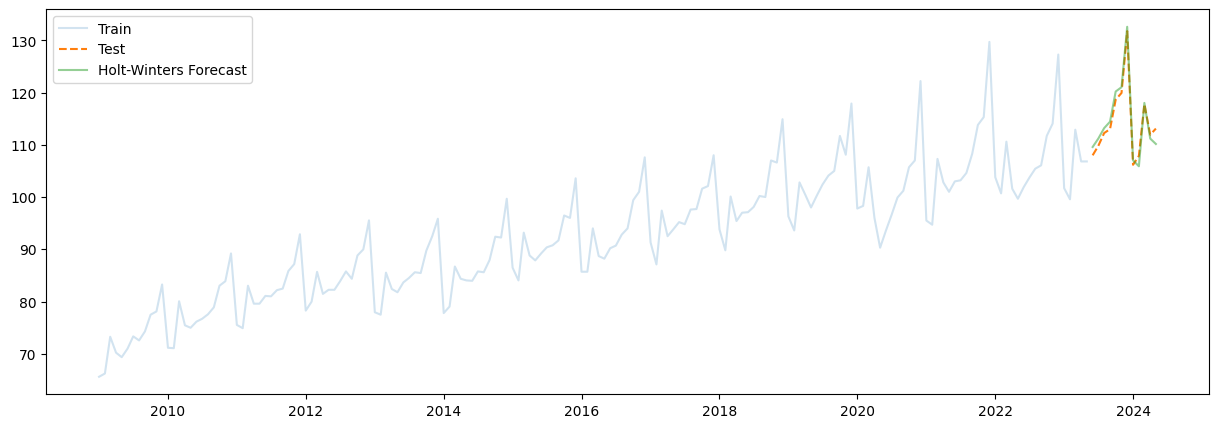

In [68]:
holt_winters_model = ExponentialSmoothing(
    train,
    seasonal="mul",
    trend="mul",
    seasonal_periods=12,
).fit()

holt_winters_forecast = holt_winters_model.forecast(steps=len(test))
plt.figure(figsize=(15, 5))
plt.plot(train, label="Train", alpha=0.2)
plt.plot(test, label="Test", linestyle="dashed")
plt.plot(test.index, holt_winters_forecast, label="Holt-Winters Forecast", alpha=0.5)
plt.legend()
plt.show()

Отличные результаты. Тут остается только метрики сравнивать.

# Сравниваем модели на метриках

In [69]:
def evaluate_model(true, predicted):
    mae = mean_absolute_error(true, predicted)
    mse = mean_squared_error(true, predicted)
    rmse = np.sqrt(mse)
    return {"MAE": mae, "MSE": mse, "RMSE": rmse}

In [70]:
arima_metrics = evaluate_model(test, arima_forecast)
arima_metrics_best = evaluate_model(test, arima_forecast_best)
sarima_metrics = evaluate_model(test, sarima_forecast)
holt_winters_metrics = evaluate_model(test, holt_winters_forecast)

print("ARIMA Metrics:", arima_metrics)
print("ARIMA Metrics Best:", arima_metrics_best)
print("SARIMA Metrics:", sarima_metrics)
print("Holt-Winters Metrics:", holt_winters_metrics)

# выбираем лучшую модель на основе RMSE
if (
    min(
        arima_metrics["RMSE"],
        arima_metrics_best["RMSE"],
        sarima_metrics["RMSE"],
        holt_winters_metrics["RMSE"],
    )
    == arima_metrics["RMSE"]
):
    print("Best Model: ARIMA")
elif (
    min(
        arima_metrics["RMSE"],
        arima_metrics_best["RMSE"],
        sarima_metrics["RMSE"],
        holt_winters_metrics["RMSE"],
    )
    == sarima_metrics["RMSE"]
):
    print("Best Model: SARIMA")
else:
    print("Best Model: Holt-Winters")

ARIMA Metrics: {'MAE': 2.4700896952116125, 'MSE': 7.9612079270892435, 'RMSE': 2.8215612570152087}
ARIMA Metrics Best: {'MAE': 1.5287319750985173, 'MSE': 3.2341399154310473, 'RMSE': 1.798371462026421}
SARIMA Metrics: {'MAE': 0.8646301870772403, 'MSE': 1.5420144084914646, 'RMSE': 1.2417787276690904}
Holt-Winters Metrics: {'MAE': 1.3007561856540935, 'MSE': 2.142755549593932, 'RMSE': 1.4638154083059558}
Best Model: SARIMA


SARIMA оказалась лучшей моделью. Но для этого пришлось подобрать оптимальные параметры. По итогу все модели показали отличные результаты. Учет сезонности в данных с сезонностью действительно повышает качество предсказания